In [2]:
import pandas as pd
import os
from datetime import datetime
import re
import matplotlib.pyplot as plt

In [142]:
def process_camera_log_mc(log_file_path):
    # Read the log file and split it into lines
    with open(log_file_path, "r") as file:
        lines = file.readlines()

    # Initialize lists to store parsed data
    pid_list = []
    uid_list = []
    start_timestamp_list = []
    afterfetch_timestamp_list = []
    afterhil_timestamp_list = []
    finish_timestamp_list = []

    if lines and "Camera started transmitting" in lines[0]:
        lines.pop(0)

    # Iterate through lines, parsing the relevant data
    for i in range(0, len(lines), 4):
        # Check if all four lines for an entity are present
        if i + 3 < len(lines):
            start_line = lines[i].split()
            afterfetch_line = lines[i + 1].split()
            afterhil_line = lines[i + 2].split()
            finish_line = lines[i + 3].split()
            
            # Check if all lines correspond to the same PID
            if (start_line[7] == afterfetch_line[7] == afterhil_line[7] == finish_line[7]) and \
               (start_line[0] == "[INFO]" and afterfetch_line[0] == "[INFO]" and afterhil_line[0] == "[INFO]" and finish_line[0] == "[INFO]"):
                pid = start_line[5]
                uid = start_line[7]
                start_timestamp = int(start_line[9])
                afterfetch_timestamp = int(afterfetch_line[9])
                afterhil_timestamp = int(afterhil_line[9])
                finish_timestamp = int(finish_line[9])

                pid_list.append(pid)
                uid_list.append(uid)
                start_timestamp_list.append(start_timestamp)
                afterfetch_timestamp_list.append(afterfetch_timestamp)
                afterhil_timestamp_list.append(afterhil_timestamp)
                finish_timestamp_list.append(finish_timestamp)

    # Create a pandas DataFrame
    data = {
        "pid": pid_list,
        "uid": uid_list,
        "start_timestamp": start_timestamp_list,
        "afterfetch_timestamp": afterfetch_timestamp_list,
        "afterhil_timestamp": afterhil_timestamp_list,
        "finish_timestamp": finish_timestamp_list
    }

    df = pd.DataFrame(data)

    # Convert timestamps to datetime objects
    df["start_timestamp"] = pd.to_datetime(df["start_timestamp"])
    df["afterfetch_timestamp"] = pd.to_datetime(df["afterfetch_timestamp"])
    df["afterhil_timestamp"] = pd.to_datetime(df["afterhil_timestamp"])
    df["finish_timestamp"] = pd.to_datetime(df["finish_timestamp"])

    return df

def process_controller_log_mc(log_file_path):
    # Read the log file and split it into lines
    with open(log_file_path, "r") as file:
        lines = file.readlines()

    # Initialize lists to store parsed data
    space_pid_list = []
    hand_pid_list = []
    uid_list = []
    space_timestamp_list = []
    hand_timestamp_list = []
    
    # Iterate through lines, parsing the relevant data
    for i in range(0, len(lines)):
        if i + 1 < len(lines):
            line = lines[i].split()
            
            pid = line[5]
            uid = line[7]
            space_timestamp = int(line[9])
            
            space_pid_list.append(pid)
            uid_list.append(uid)
            space_timestamp_list.append(space_timestamp)
                
    # Create a pandas DataFrame
    data = {
        "space_pid": space_pid_list,
        "uid": uid_list,
        "spacestate_receive": space_timestamp_list,
    }

    df = pd.DataFrame(data)

    # Convert timestamps to datetime objects
    df["spacestate_receive"] = pd.to_datetime(df["spacestate_receive"])
    return df


In [37]:
# Experiment 1, speed of processes
def process_camera_speed(directory):
    time_list = []
    avg_list = []
    cnt_list = []
    
    c_df = pd.DataFrame()
    controller_path = os.path.join(directory, "controller")
    if os.path.exists(controller_path) and os.path.isdir(controller_path):
        log_file = os.path.join(controller_path, os.listdir(controller_path)[0])
        c_df = process_controller_log_mc(log_file)

    for subdir in os.listdir(directory):
        if subdir == "controller":
            continue
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):    
            log_file = os.path.join(subdir_path, os.listdir(subdir_path)[0])
            df = process_camera_log_mc(log_file)
            if not c_df.empty:
                df = pd.merge(df, c_df, on='uid', how='left',  suffixes=('_camera', '_controller'))
                #print(df[["start_timestamp","finish_timestamp", "spacestate_receive"]])
            df.drop(df.index[0], inplace=True) # remove the record where the recognizer model gets loaded
            df["elapsed"] = df["finish_timestamp"] - df["start_timestamp"]
            df["elapsed"] = df["elapsed"].astype(int)  // 10 ** 6
            time_list.append(subdir)
            avg_list.append(df["elapsed"].mean())
            cnt_list.append(len(df))
    data = {
        "publish_time_interval" : time_list,
        "avg_process_time" : avg_list,
        "cnt": cnt_list
    }
    return pd.DataFrame(data).sort_values(by='publish_time_interval', ascending=False)


#s_dir = "/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/singlethreaded_camera"
#singlethreaded = process_singlethreaded_camera_logs(s_dir)
#print(singlethreaded)

s_dir = "/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/singlethreaded_camera"
m_dir = "/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/multithreaded_camera"

singlethreaded = process_camera_speed(s_dir)
multithreaded = process_camera_speed(m_dir)
merged_df = pd.merge(singlethreaded, multithreaded, how="inner", on="publish_time_interval", suffixes=("_single", "_multi"))
merged_df["frequency"] =  1 / merged_df["publish_time_interval"].astype(float)
merged_df["frequency"] = merged_df["frequency"].astype(str).str.rstrip('0').str.rstrip('.').str[:5]
merged_df

/home/szogabaha/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


,publish_time_interval,avg_process_time_single,cnt_single,avg_process_time_multi,cnt_multi,frequency
0,0.5,98.485686,1013,97.284515,1072,2
1,0.4,99.060297,1078,94.426181,1016,2.5
2,0.3,99.280943,1018,95.646425,1021,3.333
3,0.2,99.916585,1019,93.879530,1021,5
4,0.1,92.966245,1185,86.245714,1050,10
5,0.07,88.035038,1056,83.896392,1081,14.28
6,0.05,90.263663,1043,81.254286,1050,20
7,0.03,86.629839,1059,80.073832,1070,33.33
8,0.01,86.951659,1055,77.757944,1070,100
9,0.005,88.798839,1034,81.969089,1197,200


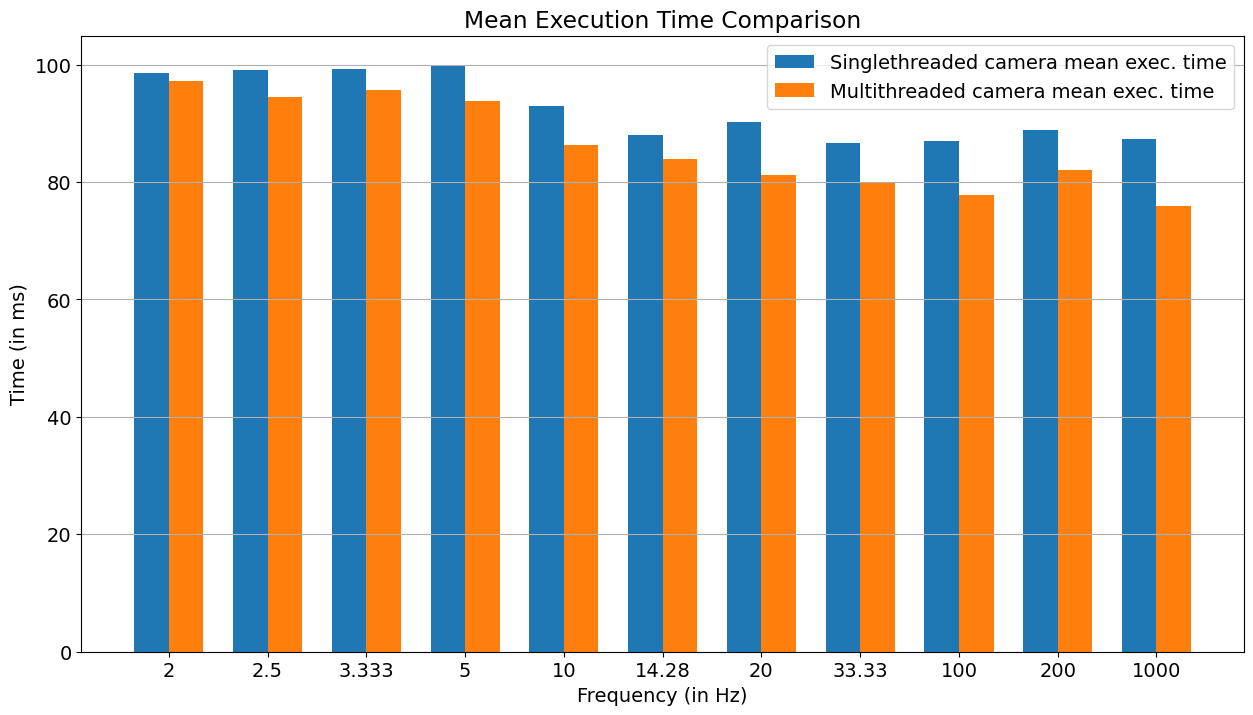

In [65]:
# Plot the bar chart
plt.figure(figsize=(15, 8))

# Define the width of each bar
bar_width = 0.35

# Define the x positions for the bars
index = merged_df.index

# Plot 'avg_process_time_single' column
plt.bar(index, merged_df['avg_process_time_single'], bar_width, label='Singlethreaded camera mean exec. time')

# Plot 'avg_process_time_multi' column
plt.bar(index + bar_width, merged_df['avg_process_time_multi'], bar_width, label='Multithreaded camera mean exec. time')

# Set labels and title
plt.xlabel('Frequency (in Hz)')
plt.ylabel('Time (in ms)')
plt.title('Mean Execution Time Comparison')
plt.xticks(index + bar_width / 2, merged_df['frequency'])  # Set x-tick labels
plt.legend()
plt.rcParams.update({'font.size': 14}) 
# Show plot
plt.grid(axis="y")
plt.show()


/home/szogabaha/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  
/home/szogabaha/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


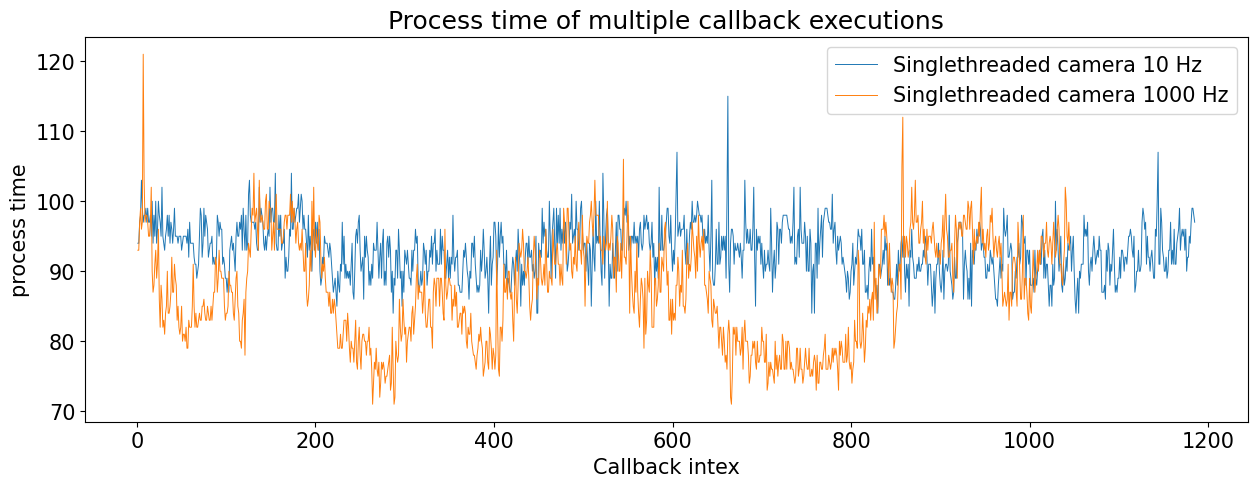

In [72]:
plt.figure(figsize=(15, 5))

point1 = process_camera_log_mc("/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/singlethreaded_camera/0.1/python3_12072_1715420885763.log")
df = pd.DataFrame()

df["0.1"] = (point1["finish_timestamp"] - point1["start_timestamp"]).astype(int) // 10 ** 6
point1 = process_camera_log_mc("/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/singlethreaded_camera/0.001/python3_16144_1715421751031.log")
df["0.001"] = (point1["finish_timestamp"] - point1["start_timestamp"]).astype(int) // 10 ** 6
df.drop(df.index[0], inplace=True)
plt.plot(df['0.1'],  linewidth=0.7, label='Singlethreaded camera 10 Hz')  # Assuming you want to mark each point with a circle marker
plt.plot(df['0.001'], linewidth=0.7, label='Singlethreaded camera 1000 Hz')  # Assuming you want to mark each point with a circle marker

plt.legend()
plt.xlabel('Callback intex')  # Label for x-axis
plt.ylabel('process time')  # Label for y-axis
plt.title('Process time of multiple callback executions')  # Title of the plot
plt.rcParams.update({'font.size': 14}) 
plt.show()

/home/szogabaha/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  
/home/szogabaha/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


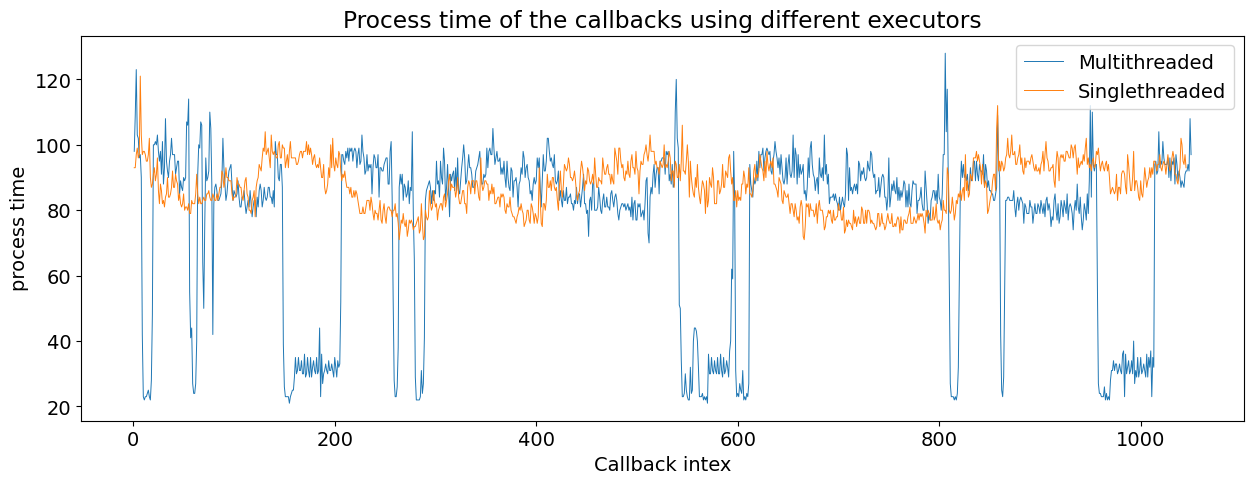

In [78]:
plt.figure(figsize=(15, 5))

point1 = process_camera_log_mc("/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/multithreaded_camera/0.001/python3_21367_1715422552761.log")
df = pd.DataFrame()

df["0.1"] = (point1["finish_timestamp"] - point1["start_timestamp"]).astype(int) // 10 ** 6
point1 = process_camera_log_mc("/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/singlethreaded_camera/0.001/python3_16144_1715421751031.log")
df["0.001"] = (point1["finish_timestamp"] - point1["start_timestamp"]).astype(int) // 10 ** 6
df.drop(df.index[0], inplace=True)
plt.plot(df['0.1'],  linewidth=0.7, label='Multithreaded')  # Assuming you want to mark each point with a circle marker
plt.plot(df['0.001'], linewidth=0.7, label='Singlethreaded')  # Assuming you want to mark each point with a circle marker

plt.legend()
plt.xlabel('Callback intex')  # Label for x-axis
plt.ylabel('process time')  # Label for y-axis
plt.title('Process time of the callbacks using different executors')  # Title of the plot
plt.rcParams.update({'font.size': 14}) 
plt.show()

In [85]:
# Experiment 2, interarrival times
def process_processed_time_interval(directory):
    time_list = []
    avg_list = []
    cnt_list = []
    
    c_df = pd.DataFrame()
    controller_path = os.path.join(directory, "controller")
    if os.path.exists(controller_path) and os.path.isdir(controller_path):
        log_file = os.path.join(controller_path, os.listdir(controller_path)[0])
        c_df = process_controller_log_mc(log_file)

    for subdir in os.listdir(directory):
        if subdir == "controller":
            continue
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):    
            log_file = os.path.join(subdir_path, os.listdir(subdir_path)[0])
            df = process_camera_log_mc(log_file)
            if not c_df.empty:
                df = pd.merge(df, c_df, on='uid', how='left',  suffixes=('_camera', '_controller'))
                #print(df[["start_timestamp","finish_timestamp", "spacestate_receive"]])
            #df["elapsed"] = df["finish_timestamp"] - df["start_timestamp"]
            #df["elapsed"] = df["elapsed"].astype(int)  // 10 ** 6
            df["finish_timestamp"] = df["finish_timestamp"].astype(int)  // 10 ** 6
            df["time_difference"] = df["finish_timestamp"].diff()
            
            df.dropna(subset=['time_difference'], inplace=True)
            time_list.append(subdir)
            avg_list.append(df["time_difference"].mean())
            cnt_list.append(len(df))
    data = {
        "publish_time_interval" : time_list,
        "avg_process_time" : avg_list,
        "cnt": cnt_list
    }
    return pd.DataFrame(data).sort_values(by='publish_time_interval', ascending=False)

s_dir = "/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/singlethreaded_camera"
m_dir = "/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/multithreaded_camera"
singlethreaded = process_processed_time_interval(s_dir)
multithreaded = process_processed_time_interval(m_dir)
merged_df = pd.merge(singlethreaded, multithreaded, on="publish_time_interval", how="inner", suffixes=('_single', '_multi'))
merged_df["frequency"] =  1 / merged_df["publish_time_interval"].astype(float)
merged_df["frequency"] = merged_df["frequency"].astype(str).str.rstrip('0').str.rstrip('.').str[:5]
merged_df


/home/szogabaha/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


,publish_time_interval,avg_process_time_single,cnt_single,avg_process_time_multi,cnt_multi,frequency
0,0.5,499.504442,1013,499.546642,1072,2
1,0.4,399.560297,1078,399.503937,1016,2.5
2,0.3,299.518664,1018,299.525955,1021,3.333
3,0.2,199.714426,1019,199.732615,1021,5
4,0.1,100.016034,1185,100.029524,1050,10
5,0.07,91.118371,1056,90.879741,1081,14.28
6,0.05,93.447747,1043,87.379048,1050,20
7,0.03,89.715770,1059,83.972897,1070,33.33
8,0.01,90.034123,1055,81.295327,1070,100
9,0.005,91.960348,1034,85.727652,1197,200


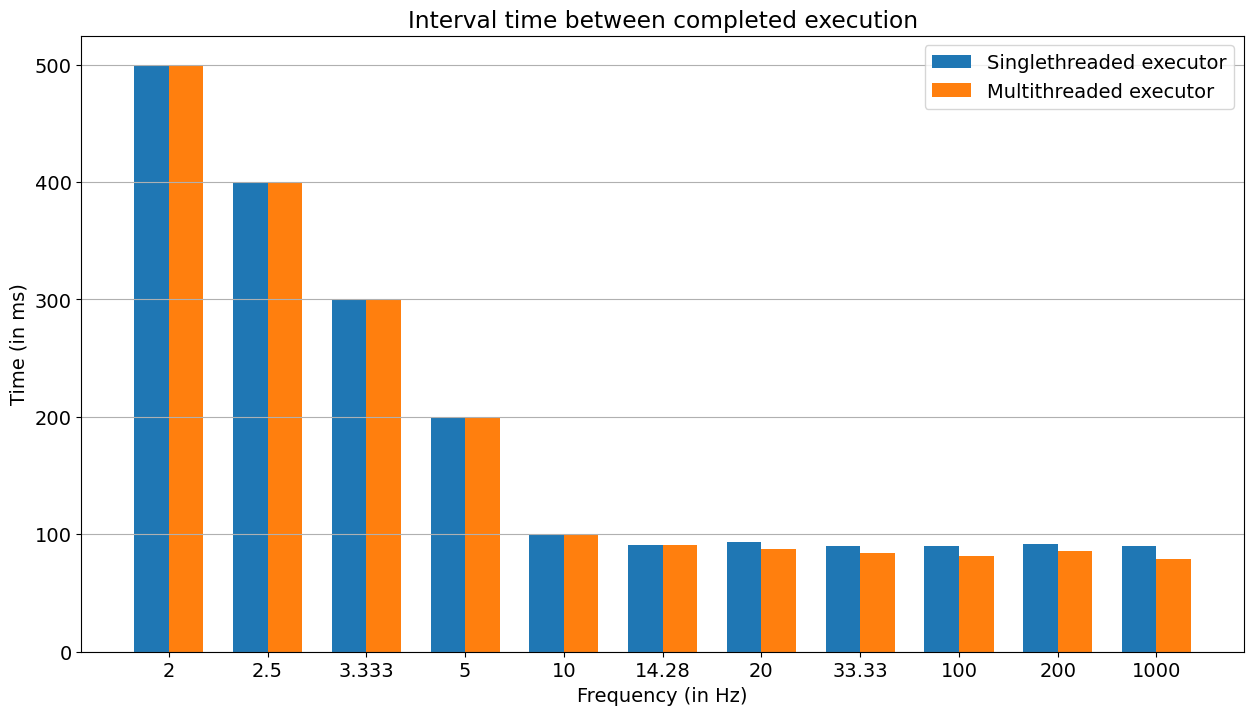

In [87]:
# Plot the bar chart
plt.figure(figsize=(15, 8))

# Define the width of each bar
bar_width = 0.35

# Define the x positions for the bars
index = merged_df.index

# Plot 'avg_process_time_single' column
plt.bar(index, merged_df['avg_process_time_single'], bar_width, label='Singlethreaded executor')

# Plot 'avg_process_time_multi' column
plt.bar(index + bar_width, merged_df['avg_process_time_multi'], bar_width, label='Multithreaded executor')

# Set labels and title
plt.xlabel('Frequency (in Hz)')
plt.ylabel('Time (in ms)')
plt.title('Interval time between completed execution')
plt.xticks(index + bar_width / 2, merged_df['frequency'])  # Set x-tick labels
plt.legend()
plt.rcParams.update({'font.size': 16}) 
# Show plot
plt.grid(axis="y")
plt.show()

In [173]:
# Experiment 3, latency (multithreaded cameras, singlethreaded controller)
def process_latency(directory):
    time_list = []
    avg_list = []
    mean_list = []
    cnt_list = []
    interval_list = []
    c_df = pd.DataFrame()
    controller_path = os.path.join(directory, "controller")
    if os.path.exists(controller_path) and os.path.isdir(controller_path):
        log_file = os.path.join(controller_path, os.listdir(controller_path)[0])
        c_df = process_controller_log_mc(log_file)

    for subdir in os.listdir(directory):
        if subdir == "controller":
            continue
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):    
            log_file = os.path.join(subdir_path, os.listdir(subdir_path)[0])
            df = process_camera_log_mc(log_file)
            original_cnt = len(df)
            if not c_df.empty:
                df = pd.merge(df, c_df, on='uid', how='inner',  suffixes=('_camera', '_controller'))
                #print(df[["start_timestamp","finish_timestamp", "spacestate_receive"]])
            df.drop(df.index[0], inplace=True) # remove the record where the recognizer model gets loaded
            df["elapsed"] = df["spacestate_receive"] - df["start_timestamp"]
            df["elapsed"] = df["elapsed"].apply(lambda x: x.total_seconds() * 1000)
            df["trans_and_queue"] = df["spacestate_receive"] - df["finish_timestamp"]
            df["trans_and_queue"] = df["trans_and_queue"].apply(lambda x: x.total_seconds() * 1000)
            df["interval"] = df["spacestate_receive"].diff().apply(lambda x: x.total_seconds() * 1000)
            df.dropna(subset=['interval'], inplace=True)
            time_list.append(subdir)
            avg_list.append(df["elapsed"].mean())
            mean_list.append(df["trans_and_queue"].mean())
            interval_list.append(df["interval"].mean())
            cnt_list.append((len(df) / original_cnt) * 100)
    data = {
        "publish_time_interval" : time_list,
        "latency" : avg_list,
        "queue_and_transmission_time" : mean_list,
        "receive_interval" : interval_list,
        "success rate": cnt_list
    }

    return pd.DataFrame(data).sort_values(by='publish_time_interval', ascending=False)


#s_dir = "/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/singlethreaded_camera"
#singlethreaded = process_singlethreaded_camera_logs(s_dir)
#print(singlethreaded)


q1 = "/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/multi_camera_single_controller_q1"
q1= process_latency(q1)
#merged_df = pd.merge(q10, q1, how="inner", on="publish_time_interval", suffixes=("_q10", "_q1"))
q1["frequency"] =  1 / q1["publish_time_interval"].astype(float)
q1["frequency"] = q1["frequency"].astype(str).str.rstrip('0').str.rstrip('.').str[:5]
q1

,publish_time_interval,latency,queue_and_transmission_time,receive_interval,success rate,frequency
5,0.1,88.639314,2.393594,100.031211,99.839099,10
1,0.07,88.554361,2.342639,92.571158,99.810066,14.28
7,0.05,79.625728,2.130515,82.609890,99.831508,20
8,0.03,83.699609,2.228603,84.835668,99.337748,33.33
4,0.01,76.932677,2.041326,77.805689,99.814471,100
0,0.005,84.105467,2.242303,85.041323,99.806014,200
6,0.001,81.830515,2.184294,82.716259,99.811143,1000
3,0.0005,82.997954,2.213816,83.912327,99.810964,2000
2,0.0001,77.653428,2.080086,78.547165,99.715100,10000


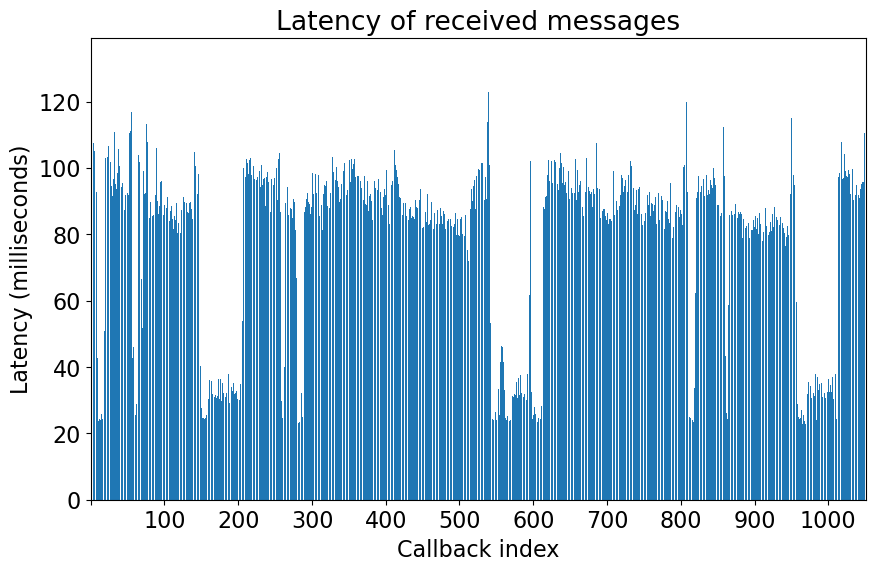

In [168]:
def calculate_latency(row):
    if pd.isna(row['spacestate_receive']):
        return 0
    else:
        return float((row['spacestate_receive'] - row['start_timestamp']).total_seconds() * 1000)


df = process_camera_log_mc("/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/multithreaded_camera/0.001/python3_21367_1715422552761.log")
c_df = process_controller_log_mc("/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/multithreaded_camera/controller/python3_21345_1715422546702.log")
df = pd.merge(df, c_df, on='uid', how='left',  suffixes=('_camera', '_controller'))
                #print(df[["start_timestamp","finish_timestamp", "spacestate_receive"]])
df.drop(df.index[0], inplace=True) # remove the record where the recognizer model gets loaded
df["latency"] = df.apply(lambda row: calculate_latency(row), axis=1)


plt.figure(figsize=(10, 6))

# Define the width of each bar
df['latency'].plot(kind='bar', width=0.8)

# Setting labels and title
plt.xlabel('Callback index')
plt.ylabel('Latency (milliseconds)')
plt.title('Latency of received messages')
plt.xticks(range(-1, 1001, 100))
plt.xticks(rotation=0)
# Display the plot
plt.show()

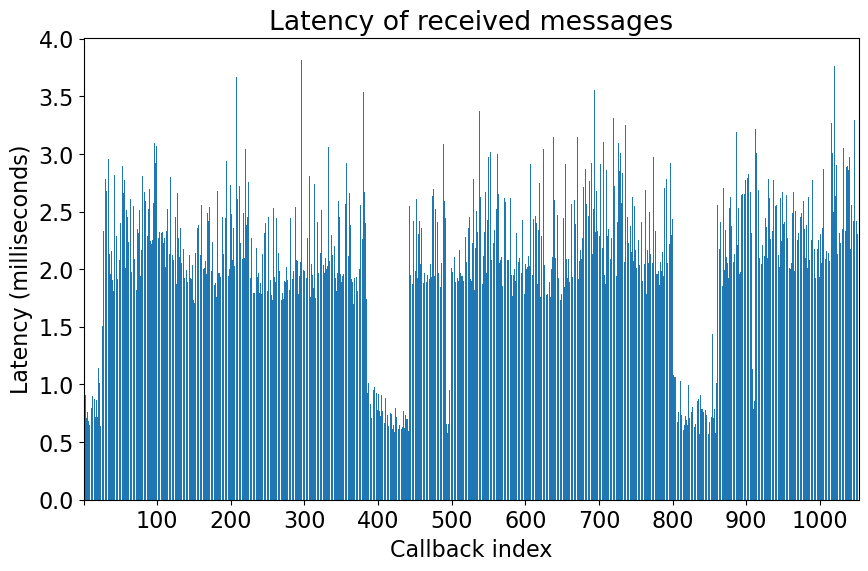

In [162]:
def calculate_latency(row):
    if pd.isna(row['spacestate_receive']):
        return 0
    else:
        return float((row['spacestate_receive'] - row['finish_timestamp']).total_seconds() * 1000)


df = process_camera_log_mc("/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/multi_camera_single_controller_q1/0.0001/python3_36627_1715426494883.log")
c_df = process_controller_log_mc("/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed_again/multi_camera_single_controller_q1/controller/python3_30936_1715425319870.log")
df = pd.merge(df, c_df, on='uid', how='left',  suffixes=('_camera', '_controller'))
                #print(df[["start_timestamp","finish_timestamp", "spacestate_receive"]])
df.drop(df.index[0], inplace=True) # remove the record where the recognizer model gets loaded
df["latency"] = df.apply(lambda row: calculate_latency(row), axis=1)


plt.figure(figsize=(10, 6))

# Define the width of each bar
df['latency'].plot(kind='bar', width=0.8)

# Setting labels and title
plt.xlabel('Callback index')
plt.ylabel('Latency (milliseconds)')
plt.title('Latency of received messages')
plt.xticks(range(-1, 1001, 100))
plt.xticks(rotation=0)
# Display the plot
plt.show()

In [167]:
df["t"] = df["spacestate_receive"].diff()
df["t"] = df["t"].apply(lambda x: x.total_seconds())
df[df["t"] < 0]

,pid,uid,start_timestamp,afterfetch_timestamp,afterhil_timestamp,finish_timestamp,space_pid,spacestate_receive,latency,t
